# <div align="center">Dealing with Imbalanced Data</div>
---------------------------------------------------------------------

you can Find me on Github:
> ###### [ GitHub](https://github.com/lev1khachatryan)

<img src="asset/main.jpg" />

Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. Class imbalance can be found in many different areas including medical diagnosis, spam filtering, and fraud detection.

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score


users = pd.read_csv('input/All_Users.csv')
KPIs = pd.read_csv('input/KPIs_2&3.csv')

Activities = pd.merge(users, KPIs)
Activities.fillna(0, inplace =True)
Activities['Learn'] = Activities.L + Activities.UL
Activities['Social_1'] = Activities.UC + Activities.UP + Activities.DP
Activities['Social_2'] = Activities.CP + Activities.P + Activities.OP



Checkins = pd.read_csv('input/Checkins_4,5&6.csv')
retained_activities = pd.read_csv('input/KPIs_4,5&6.csv')

Retention = pd.merge(pd.merge(users, Checkins, how = 'left'), retained_activities)
Retention.fillna(0, inplace =True)
Retention['Learn'] = Retention.L + Retention.UL
Retention['Social_1'] = Retention.UC + Retention.UP + Retention.DP
Retention['Social_2'] = Retention.CP + Retention.P + Retention.OP
Retention['Total'] = Retention.Learn + Retention.Social_1 + Retention.Social_2
Retention['y'] = np.where((Retention.NofCheckins > 0) & (Retention.Total >= 3) & (Retention.Learn >= 0) & (Retention.Social_1 >= 0), 1 , 0)


# columns to use
X_col = ['UC', 'UP', 'DP', 'CP', 'L', 'UL', 'P', 'OP', 'F']
# X_col = ['Learn', 'Social_1', 'Social_2']

y_col = 'y'

X = Activities[X_col]
y = Retention[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) # 75% training and 25% test


print('The percentage of negative class is: {}'.format((y[y == 0].shape[0] / y.shape[0])* 100))
print('The percentage of positive class is: {}'.format((y[y == 1].shape[0] / y.shape[0])* 100))


The percentage of negative class is: 85.04514576798779
The percentage of positive class is: 14.954854232012208


### Our objective will be to correctly classify the minority class.

# <div align="center">The Problem with Imbalanced Classes</div>
---------------------------------------------------------------------
Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error.

### The Problem with Accuracy
Here we can use the DummyClassifier to always predict “not fraud” just to show how misleading accuracy can be.

In [24]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.8508376660889659


We got an accuracy score of 85.08% — And without even training a model! Let’s compare this to logistic regression, an actual trained classifier.

In [27]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

# Checking accuracy
print('Accuracy: ', accuracy_score(y_test, lr_pred))

# Checking unique values
predictions = pd.DataFrame(lr_pred)
print(predictions[0].value_counts())

Accuracy:  0.8626635402861318
0    142939
1      4196
Name: 0, dtype: int64


### Let’s take a look at some popular methods for dealing with class imbalance.

# <div align="center">1. Change the performance metric</div>
---------------------------------------------------------------------

As we saw above, accuracy is not the best metric to use when evaluating imbalanced datasets as it can be very misleading. 


Metrics that can provide better insight include:

* Confusion Matrix: a table showing correct predictions and types of incorrect predictions.


* Precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.


* Recall: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.


* F1: Score: the weighted average of precision and recall.


Let’s see what happens when we apply these F1 and recall scores to our logistic regression from above.

In [28]:
# f1 score
print(f1_score(y_test, lr_pred))

# recall score
print(recall_score(y_test, lr_pred))

0.2270588685307731
0.1352348840388208


These scores don’t look quite so impressive. Let’s see what other methods we might try to improve our new metrics.

# <div align="center">2. Change the algorithm</div>
---------------------------------------------------------------------

While in every machine learning problem, it’s a good rule of thumb to try a variety of algorithms, it can be especially beneficial with imbalanced datasets. Decision trees frequently perform well on imbalanced data. They work by learning a hierarchy of if/else questions and this can force both classes to be addressed.

In [31]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, rfc_pred))

print('F1 Score: ', f1_score(y_test, rfc_pred))

print('Recall: ', recall_score(y_test, rfc_pred))

Accuracy:  0.859455601998165
F1 Score:  0.31786244433448785
Recall:  0.21952886499293753


While our accuracy score is slightly lower, both F1 and recall have increased as compared to logistic regression! It appears that for this specific problem, random forest may be a better choice of model.

# <div align="center">3. Resampling Techniques — Oversample minority class</div>
---------------------------------------------------------------------

Our next method begins our resampling techniques.

Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

### Important Note
Always split into test and train sets BEFORE trying oversampling techniques! Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets. This can allow our model to simply memorize specific data points and cause overfitting and poor generalization to the test data.

In [64]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
negative_class = X[X.y==0]
positive_class = X[X.y==1]

# upsample minority
positive_class_upsampled = resample(positive_class,
                          replace=True, # sample with replacement
                          n_samples=len(negative_class), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([negative_class, positive_class_upsampled])

# check new class counts
upsampled.y.value_counts()

1    375335
0    375335
Name: y, dtype: int64

After resampling we have an equal ratio of data points for each class! Let’s try our logistic regression again with the balanced training data.

In [65]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.y
X_train = upsampled.drop('y', axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, upsampled_pred))

print('F1 Score: ', f1_score(y_test, upsampled_pred))

print('Recall: ', recall_score(y_test, upsampled_pred))

print('Precision: ', precision_score(y_test, upsampled_pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, upsampled_pred))


Accuracy:  0.8498725660108064
F1 Score:  0.45023519749122676
Recall:  0.41212922039458694
Precision:  0.496105748135147
Balanced Accuracy:  0.6693717961895611


# <div align="center">4. Resampling techniques — Undersample majority class</div>
---------------------------------------------------------------------

Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class.

In [38]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
negative_class_downsampled = resample(negative_class,
                                replace = False, # sample without replacement
                                n_samples = len(positive_class), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([negative_class_downsampled, positive_class])

# checking counts
downsampled.y.value_counts()

1    66068
0    66068
Name: y, dtype: int64

In [43]:
# trying logistic regression again with the undersampled dataset

# y_train = downsampled.y
# X_train = downsampled.drop('y', axis=1)

undersampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

undersampled_pred = undersampled.predict(X_test)

# Checking accuracy
print('Accuracy: ', accuracy_score(y_test, undersampled_pred))

# f1 score
print('F1 Score: ', f1_score(y_test, undersampled_pred))

print('Recall: ', recall_score(y_test, undersampled_pred))

print('Precision: ', precision_score(y_test, undersampled_pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, undersampled_pred))


Accuracy:  0.8496346892309784
F1 Score:  0.4488565592147875
Recall:  0.4104889050895339
Precision:  0.49513602638087384
Precision:  0.668555632530069


# <div align="center">5. Generate synthetic samples</div>
---------------------------------------------------------------------

A technique similar to upsampling is to create synthetic samples. Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

Again, it’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

In [49]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 42, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

After generating our synthetic data points, let’s see how our logistic regression performs

In [50]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, smote_pred))

print('F1 Score: ', f1_score(y_test, smote_pred))

print('Recall: ', recall_score(y_test, smote_pred))

print('Precision: ', precision_score(y_test, smote_pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, smote_pred))

Accuracy:  0.8496346892309784
F1 Score:  0.4488565592147875
Recall:  0.4104889050895339
Precision:  0.49513602638087384
Balanced Accuracy:  0.668555632530069


# <div align="center">6. Decision Tree</div>
---------------------------------------------------------------------


In [66]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 5,
    max_features = 5,
    min_samples_leaf = 10,
    min_samples_split = 0.1)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)


print('Accuracy: ', accuracy_score(y_test, pred))

print('F1 Score: ', f1_score(y_test, pred))

print('Recall: ', recall_score(y_test, pred))

print('Precision: ', precision_score(y_test, pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, pred))

Accuracy:  0.7900091752472219
F1 Score:  0.46334219165233703
Recall:  0.607736820522167
Precision:  0.3743894908213103
Balanced Accuracy:  0.7148502935086791


In [61]:
X_test.columns.values

array(['UC', 'UP', 'DP', 'CP', 'L', 'UL', 'P', 'OP', 'F'], dtype=object)

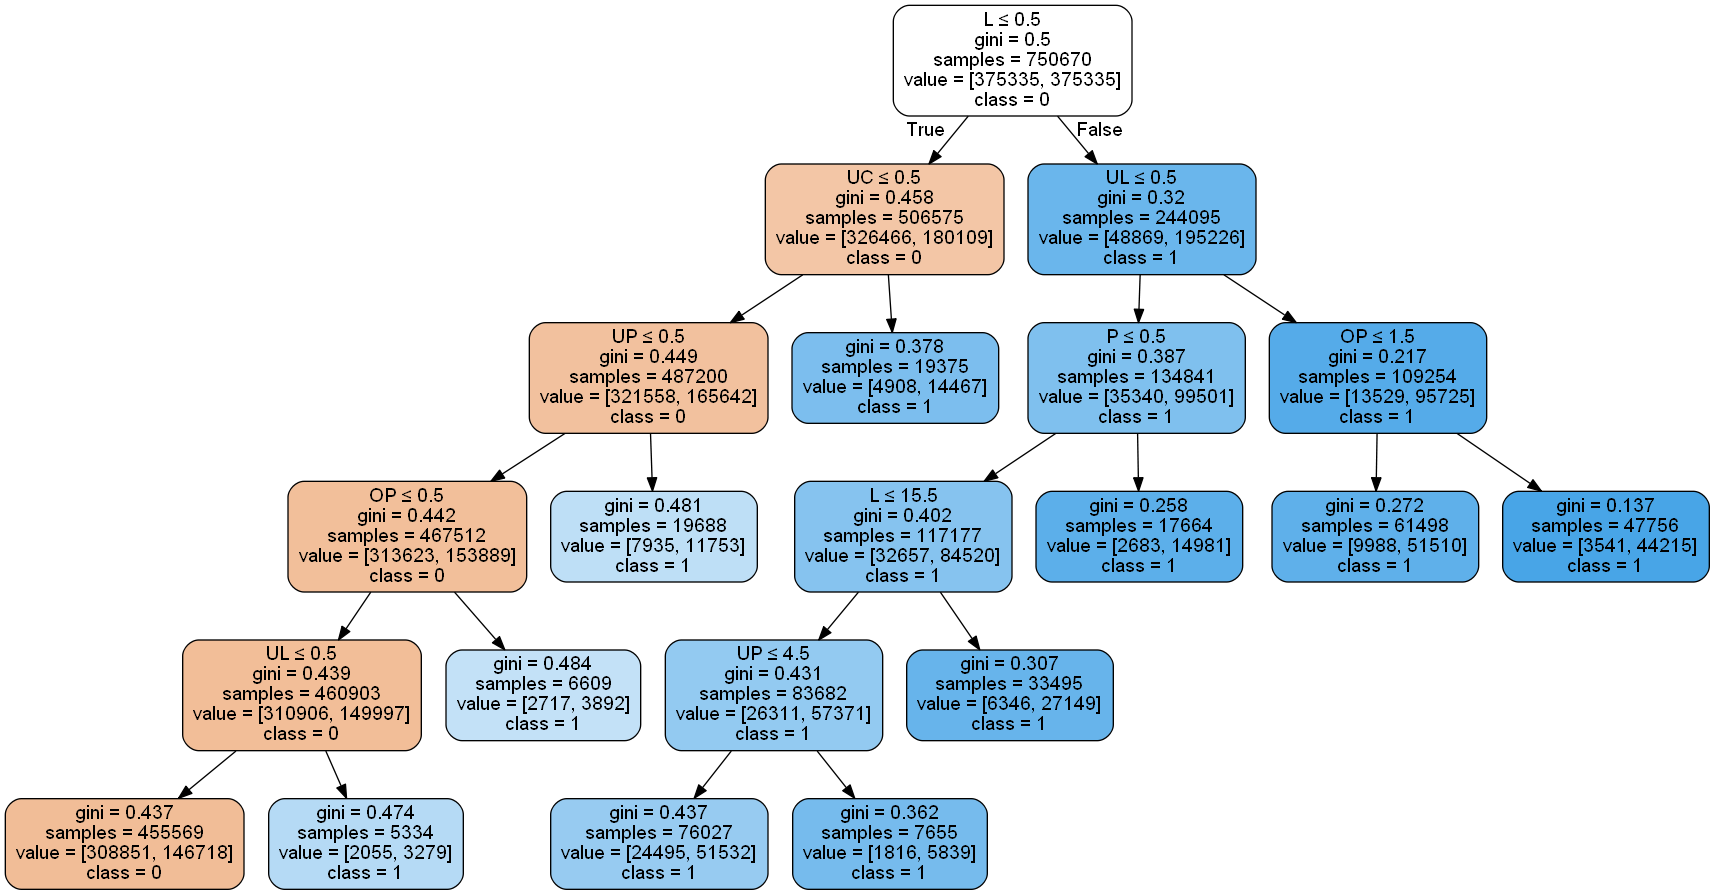

In [67]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()

export_graphviz(clf, 
                out_file = dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True, 
                feature_names = X_test.columns.values, 
                class_names=['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  


# graph.write_png('UserActivity_2.png')

Image(graph.create_png())

# <div align="center">7. Random Forest</div>
---------------------------------------------------------------------

In [68]:
clf = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='entropy')

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)


print('Accuracy: ', accuracy_score(y_test, pred))

print('F1 Score: ', f1_score(y_test, pred))

print('Recall: ', recall_score(y_test, pred))

print('Precision: ', precision_score(y_test, pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, pred))

Accuracy:  0.7886023040065246
F1 Score:  0.4633725544322142
Recall:  0.611883173098829
Precision:  0.37287241427183115
Balanced Accuracy:  0.7157332598727362


In [70]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()

export_graphviz(clf, 
                out_file = dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True, 
                feature_names = X_test.columns.values, 
                class_names=['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  


graph.write_png('RandomForest_1.png')

Image(graph.create_png())